# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features

### Load data and create binary masks 

In [38]:
%%time
# io
fname = "/media/scholz_la/hd3/20200130_NZ0028/*.tiff"
parameterfile = "/home/scholz_la/Desktop/pumping/PharaGlow/pharaglow_parameters_GRU101.txt"
outfile = "/media/scholz_la/hd3/20200130_NZ0028_MKS_{}_{}.json"
lawnfile = '/media/scholz_la/hd2/Nicolina/Nicolina/Lawns/NZ0028_lawn.tiff'
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)


Loading parameters from ['PharaGlow', 'pharaglow_parameters_GRU101.txt']
CPU times: user 6.34 ms, sys: 934 µs, total: 7.27 ms
Wall time: 716 µs


In [39]:
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes[:18000]

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)

Starting pharaglow analysis...
open and binarize lawn file


In [45]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate = 4, tfactor =0.5)# param['tfactor'])                             )


Binarizing images
CPU times: user 2min 23s, sys: 13.2 s, total: 2min 36s
Wall time: 26.6 s


### Make sure the thesholding worked otherwise change parameters

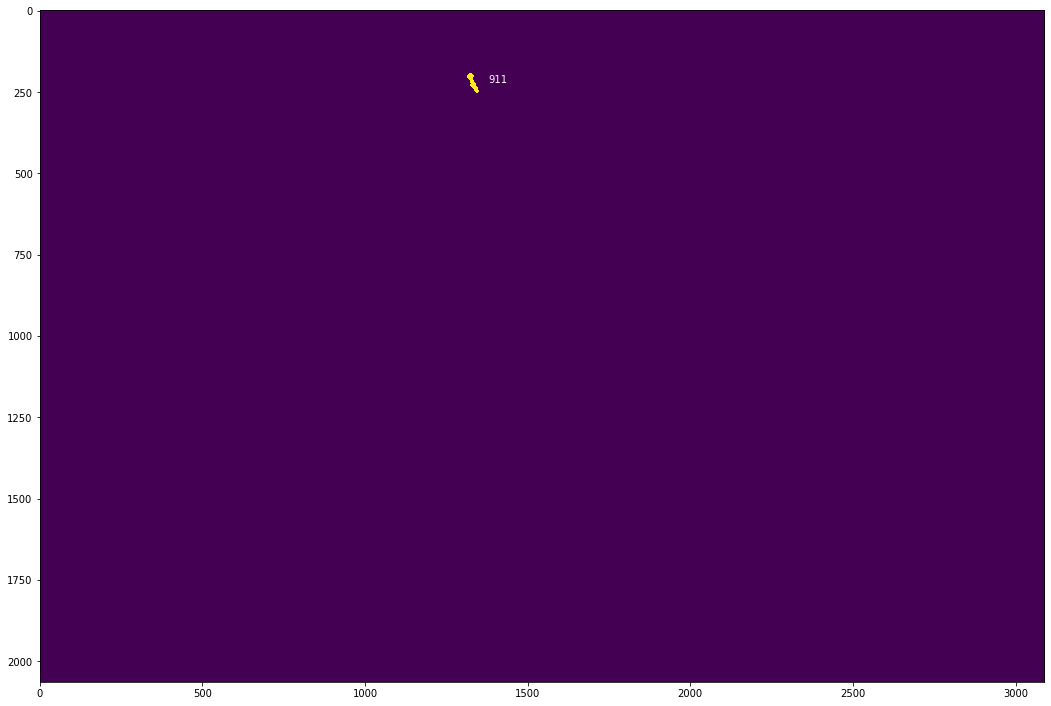

In [54]:
from skimage.measure import label, regionprops
t =1200
plt.figure(figsize=(18,16))
# plt.subplot(121)
#plt.imshow(rawframes[t])#+lawn)
#plt.colorbar()
# plt.subplot(122)
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [55]:
%%time
import time

nWorkers = 10
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        #print(a,b)
        return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
        #print(p, time.time()-start)
    features = pd.concat(features)
    p.close()
    p.join()

Detecting features
9001
Expected time is approx. 1409.761693109936 s
CPU times: user 2.14 s, sys: 2.38 s, total: 4.53 s
Wall time: 25min 41s


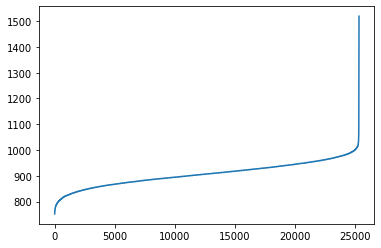

In [56]:
### Save the features
plt.plot(np.sort(features['area'].values))

In [57]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25337 entries, 0 to 0
Data columns (total 8 columns):
area     25337 non-null int64
frame    25337 non-null int64
image    25337 non-null object
slice    25337 non-null object
x        25337 non-null float64
xw       25337 non-null float64
y        25337 non-null float64
yw       25337 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 5.0 MB


In [79]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

### Link objects to trajectories and interpolate short misses

In [58]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 20, memory= 15)

Frame 9000: 3 trajectories present.


In [59]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj)

Interpolating trajectories


In [60]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,600)
print(trajectories['particle'].nunique())

36
16


### Save / Load trajectories if you need to have a checkpoint

In [ ]:
trajectories.to_json(outfile.format('trajectories', 'all'), orient='split')

In [ ]:
trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
trajectories['image'].replace('None', np.nan, inplace=True)

In [ ]:
trajectories['image'].replace([None], np.nan, inplace=True)

### add the missing images to interpolated trajectories

In [61]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
trajectories[['image']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                                length=param['length'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else row['image'], axis=1)

Fill in missing images
CPU times: user 1min 15s, sys: 32.2 s, total: 1min 48s
Wall time: 5min 55s


In [81]:
%xdel rawframes 

### Extract lawn info

In [62]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

CPU times: user 4.41 s, sys: 0 ns, total: 4.41 s
Wall time: 4.46 s


### Show resulting trajectories

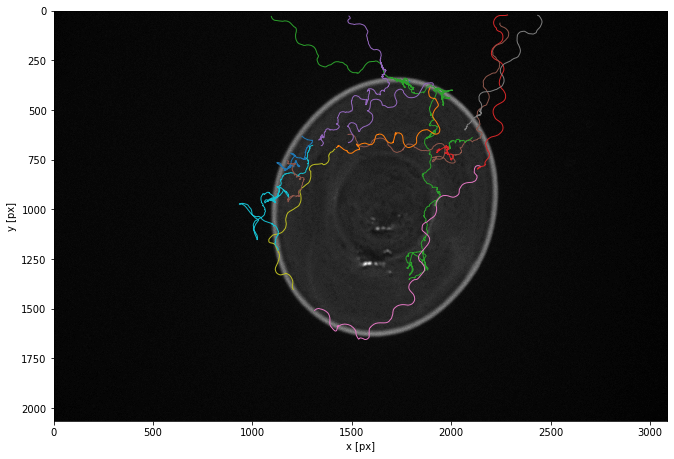

In [63]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=lawn);

### write trajectories to file

In [64]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', particle_index), orient='split')

### Read in all trjectories and redo lawn analysis if neccessary.

In [ ]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file =os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        if particle_index >=19:
            continue
        traj =  pd.read_json(file, orient='split', numpy = True)
        print('Analyzing trajectory:', fn)
        traj['inside'] = traj.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)
        traj.to_json(outfile.format('trajectories', particle_index), orient='split')

### check slow-down before continuing analysis

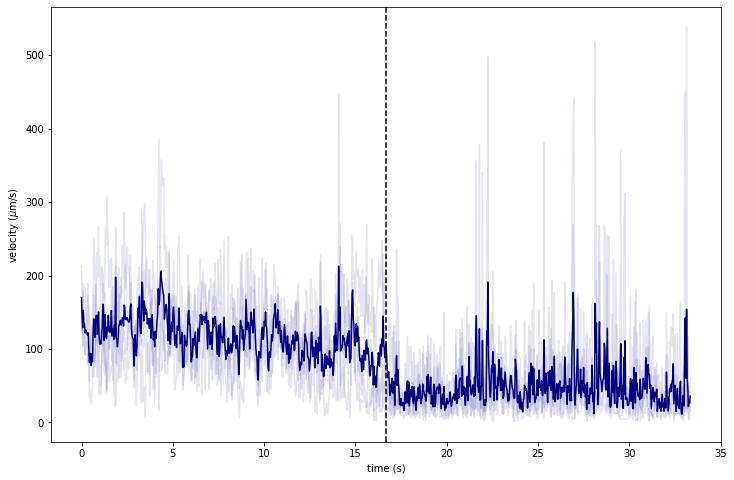

In [87]:
plt.figure(figsize=(12,8))
vcut = []
dt = 500
for pid in trajectories['particle'].unique():
    tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
    f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
    if f<0.9 and f>0.01:
        t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
        if t0>dt:
            time = np.linspace(0,2*dt/30., 2*dt)
            v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
            plt.plot(time, v.iloc[t0-dt:t0+dt].values, 'navy', alpha=0.1)
            vcut.append(v.iloc[t0-dt:t0+dt].values)
plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
plt.axvline(dt/30, color='k', linestyle='--')
plt.ylabel(r"velocity ($\mu$m/s)");
plt.xlabel("time (s)");


### run the whole pharaglow feature extraction

In [ ]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores//5)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

### Save data as hdf5 format (every trajectory in a file)

In [ ]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file =os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split', numpy = True)
        print('Analyzing trajectory:', fn)
        try:
            tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = 5, params = param)
            tmp.to_json(outfile.format('results', particle_index), orient='split')
        except ValueError:
            continue

In [ ]:
file =os.path.join(path,fn)

In [ ]:
traj =  pd.read_json(file, orient='split', numpy = True)

In [ ]:
plt.imshow(np.array(traj['image'].loc[7333]).reshape((100,100)))

In [ ]:
plt.plot(traj['x'].loc[7330:7360], traj['y'].loc[7330:7360])